# 서울 지하철 유동인구·사고 분석

2020–2024년 서울교통공사 공공데이터를 활용하여 **시간대별·역별 유동인구**와 **사고유형별 역별 사고 건수**를 분석하고, 두 지표를 결합해 **역별 사고비율**을 계산합니다.

순서는 다음과 같습니다:
1. 라이브러리 및 한글 폰트 설정
2. 전처리 함수 정의
3. 데이터 불러오기
4. 연도별 시간대 평균 유동인구 분석·시각화
5. 사고유형별,시간대별별 역별 사고 건수 집계 및 시각화
6. 사고비율(사고건수/평균유동인구) 시각화
7. 소방시설

## 라이브러리 및 한글 폰트 설정

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False


## 역명 전처리 함수 정의

In [4]:

def normalize_station(name: str) -> str:
    """괄호 및 '역' 제거 후 공백 정리"""
    name = str(name)
    name = re.sub(r'\(.*?\)', '', name)  # 괄호 내용 제거
    return name.replace('역', '').strip()


## 데이터 불러오기

In [5]:

# 연도별 시간대 승·하차 데이터 (경로는 노트북과 같은 폴더에 위치한다고 가정)
yearly_files = {
    2020: "서울교통공사_역별 시간대별 승하차인원(20.1~20.12).csv",
    2021: "서울교통공사_역별 시간대별 승하차인원(21.1~21.12).csv",
    2022: "서울교통공사_역별 시간대별 승하차인원(22.1~22.12).csv",
    2023: "서울교통공사_역별 시간대별 승하차인원(23.1~23.12).csv",
    2024: "서울교통공사_역별 시간대별 승하차인원(24.1~24.12).csv"
}

# 사고 데이터
accident_df = pd.read_csv("서울교통공사_최근 5년 지하철 사고 현황_20250310.csv", encoding="cp949")

machine_path = "서울교통공사_기계시설정보_20250310.csv"
arch_path = "서울교통공사_역사건축정보_20250310.csv"

# 인코딩 주의: cp949 사용
machine_df = pd.read_csv(machine_path, encoding='cp949')
arch_df = pd.read_csv(arch_path, encoding='cp949')

## 사고유형별 역별 사고 건수 집계 및 시각화

In [6]:
# 사고유형별 건수와 비율 확인
type_counts = (accident_df['사고유형']
               .value_counts()
               .reset_index(name='건수')
               .rename(columns={'index':'사고유형'}))

type_counts['비율(%)'] = (type_counts['건수'] /
                         type_counts['건수'].sum() * 100).round(1)




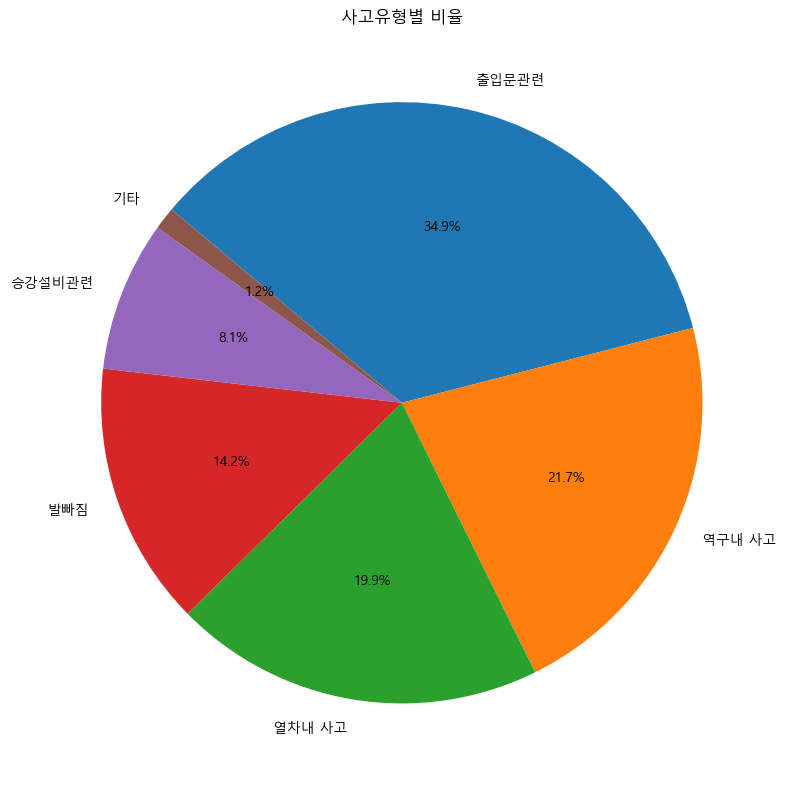

In [7]:
# 사고유형별 건수 및 비율 계산
type_counts = (accident_df['사고유형']
               .value_counts()
               .reset_index(name='건수')
               .rename(columns={'index': '사고유형'}))

type_counts['비율(%)'] = (type_counts['건수'] /
                         type_counts['건수'].sum() * 100).round(1)

# 원 그래프 시각화
plt.figure(figsize=(8, 8))
plt.pie(
    type_counts['건수'],
    labels=type_counts['사고유형'],
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False
)
plt.title('사고유형별 비율')
plt.axis('equal')
plt.tight_layout()
plt.show()


유동인구별 사고건수

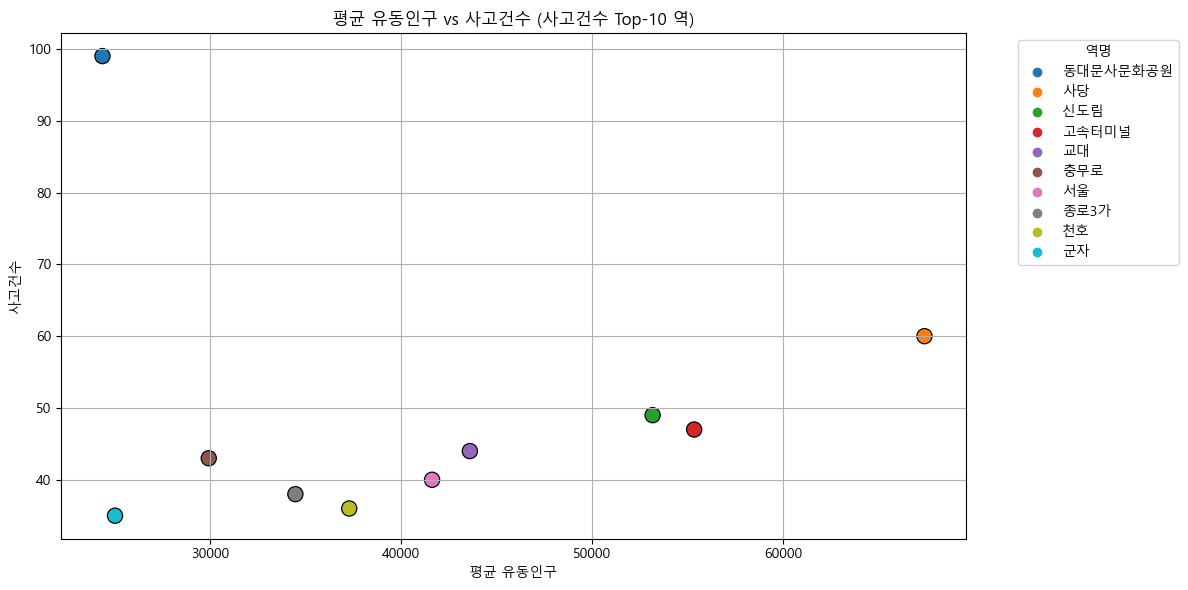

In [8]:
import pandas as pd, glob, re, platform
import matplotlib.pyplot as plt, seaborn as sns

# 1) 카드데이터 불러와 avg_pop 생성
def normalize_station(name):
    name = re.sub(r'\(.*?\)', '', str(name))
    return name.replace('역', '').strip()

card_files = glob.glob("CARD_SUBWAY_MONTH_*.csv")
card_df_list = []

for fp in card_files:
    try:
        tmp = pd.read_csv(fp, encoding='utf-8', header=1)
    except UnicodeDecodeError:
        tmp = pd.read_csv(fp, encoding='cp949', header=1)

    if tmp.shape[1] == 7:
        tmp.columns = ['사용일자','노선','역명','승차','하차','등록일자','tmp']
        tmp = tmp.drop(columns=['tmp'])
    else:
        tmp.columns = ['사용일자','노선','역명','승차','하차','등록일자']

    tmp['총이용객'] = pd.to_numeric(tmp['승차'], errors='coerce') + pd.to_numeric(tmp['하차'], errors='coerce')
    tmp['정규역명'] = tmp['역명'].apply(normalize_station)
    card_df_list.append(tmp)

card_df = pd.concat(card_df_list, ignore_index=True)
day_counts = card_df.groupby('정규역명').size()
total_pop = card_df.groupby('정규역명')['총이용객'].sum()
avg_pop = (total_pop / day_counts).rename('평균유동인구').reset_index()

# 2) 사고데이터 불러오기
accident_df = pd.read_csv("서울교통공사_최근 5년 지하철 사고 현황_20250310.csv", encoding='cp949')
accident_df['정규역명'] = accident_df['발생역'].apply(normalize_station)

# 3) 사고건수 집계 및 병합
accident_counts = (accident_df['정규역명']
                   .value_counts()
                   .reset_index(name='사고건수')
                   .rename(columns={'index': '정규역명'}))

metrics = (accident_counts
           .merge(avg_pop, on='정규역명', how='left')
           .dropna(subset=['평균유동인구'])
           .sort_values('사고건수', ascending=False)
           .reset_index(drop=True))

top10 = metrics.head(10)

# 4) 시각화
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=top10,
    x='평균유동인구',
    y='사고건수',
    hue='정규역명',
    palette='tab10',
    s=120,
    edgecolor='k'
)
plt.title('평균 유동인구 vs 사고건수 (사고건수 Top-10 역)')
plt.xlabel('평균 유동인구')
plt.ylabel('사고건수')
plt.legend(title='역명', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# 6. 사고유형별 - 역별 사고 건수 집계 (표만 출력)

# 역명 전처리
accident_df['정규역명'] = accident_df['발생역'].apply(normalize_station)

# 사고유형·역 기준 건수 집계
acc_group = (accident_df
             .groupby(['정규역명', '사고유형'])
             .size()
             .reset_index(name='사고건수'))

# 피벗테이블 변환
pivot = acc_group.pivot_table(index='정규역명',
                              columns='사고유형',
                              values='사고건수',
                              fill_value=0)

# 사고 총합 기준 상위 10개 역
top10 = pivot.sum(axis=1).nlargest(10).index
top10_pivot = pivot.loc[top10].astype(int)   # 정수 변환
top10_pivot['total'] = top10_pivot.sum(axis=1)  # 총합 열 추가
# 표 출력
top10_pivot


사고유형,기타,발빠짐,승강설비관련,역구내 사고,열차내 사고,출입문관련,total
정규역명,,,,,,,
동대문사문화공원,0,48,1,6,6,38,99
사당,0,5,2,16,16,21,60
신도림,0,0,5,10,16,18,49
고속터미널,0,21,7,6,5,8,47
교대,1,2,1,10,7,23,44
충무로,0,19,4,2,3,15,43
서울,0,14,1,4,7,14,40
종로3가,1,2,4,8,6,17,38
천호,1,1,3,3,8,20,36


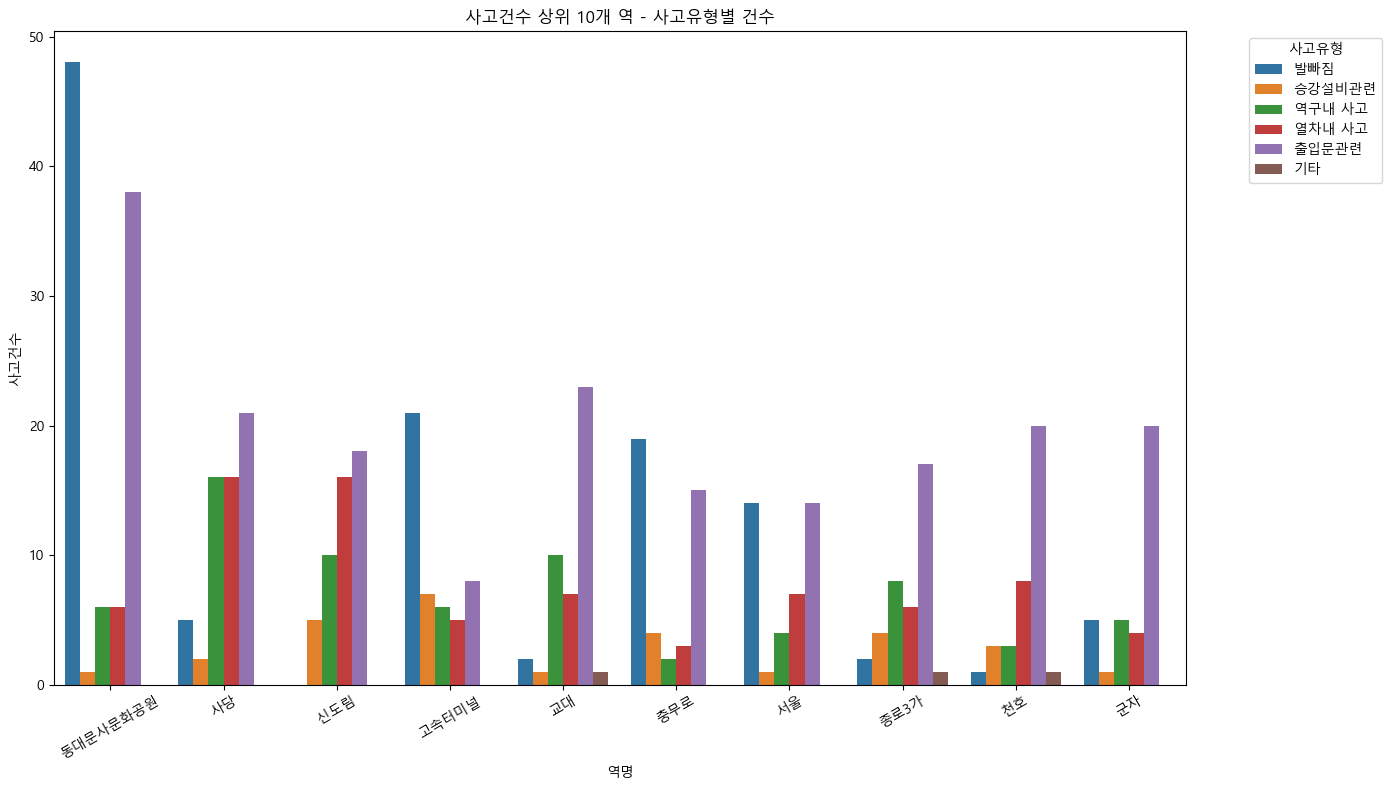

In [10]:
# ──────────────────────────────────────────────────────────────
# 사고건수 상위 10개 역 - 사고유형별 건수 집계 + 시각화
# ──────────────────────────────────────────────────────────────

# 1) 역명 전처리
accident_df['정규역명'] = accident_df['발생역'].apply(normalize_station)

# 2) 사고유형별·역별 건수 집계
type_by_station = (accident_df
                   .groupby(['정규역명', '사고유형'])
                   .size()
                   .reset_index(name='사고건수'))

# 3) 사고 총합 Top-10 역 추출
accident_top10 = (accident_df['정규역명']
                  .value_counts()
                  .head(10)
                  .reset_index(name='total_accidents')
                  .rename(columns={'index': '정규역명'}))

# 4) 사고유형 세부 집계와 병합
type_top10 = (type_by_station
              .merge(accident_top10, on='정규역명')
              .sort_values(['total_accidents', '정규역명'], ascending=[False, True]))

# 5) 시각화 ─ 바 차트 (역 × 사고유형)
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 한글 폰트 설정
if platform.system() == "Windows":
    plt.rc("font", family="Malgun Gothic")
elif platform.system() == "Darwin":
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="NanumGothic")
plt.rcParams["axes.unicode_minus"] = False

plt.figure(figsize=(14, 8))
sns.barplot(
    data=type_top10,
    x='정규역명',
    y='사고건수',
    hue='사고유형',
    dodge=True
)
plt.title('사고건수 상위 10개 역 - 사고유형별 건수')
plt.xlabel('역명')
plt.ylabel('사고건수')
plt.xticks(rotation=30)
plt.legend(title='사고유형', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
